In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection


file_path = "output/electrode_npp_3d_results.npz"

data = np.load(file_path)
nodes = data['nodes']
elements = data['elements']
c1_history = data['c1_history']
c2_history = data['c2_history']
phi_history = data['phi_history']
dt = data['dt'].item()  # Use .item() to get scalar value
num_steps = c1_history.shape[0]
phi_c = data['phi_c'].item()
tau_c = data['tau_c'].item()

In [141]:
c1_history.shape

(11, 1331)

In [142]:
phi = pd.DataFrame(phi_history)

In [143]:
phi.head()

,0,1,2,3,4,5,6,7,8,9,...,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.027481,0.027746,0.027845,0.027366,0.026267,0.024667,0.022714,0.020567,0.018433,0.016685,...,0.036310,0.035290,0.033782,0.032012,0.030172,0.028416,0.026871,0.025646,0.024843,0.024527
2,0.027507,0.027773,0.027872,0.027393,0.026293,0.024691,0.022736,0.020587,0.018451,0.016701,...,0.036346,0.035324,0.033815,0.032043,0.030201,0.028444,0.026897,0.025671,0.024867,0.024551
3,0.027507,0.027773,0.027872,0.027393,0.026293,0.024691,0.022736,0.020587,0.018451,0.016701,...,0.036346,0.035324,0.033815,0.032043,0.030201,0.028444,0.026897,0.025671,0.024867,0.024551
4,0.005520,0.005304,0.004892,0.004427,0.003978,0.003566,0.003192,0.002854,0.002553,0.002319,...,0.003486,0.003434,0.003355,0.003260,0.003161,0.003070,0.002995,0.002938,0.002903,0.002890


In [144]:
np.sum(c1_history[0])- np.sum(c1_history[-1])

np.float64(-0.3306822781377434)

In [145]:
# k=0.5 -> -0.49
# k=5 -> -4.05

# k = 1; T = 400 -> -4.65
# k = -1; T = 400 

ValueError: 'vertices' must be 2D with shape (N, 2), but your input has shape (5, 3)

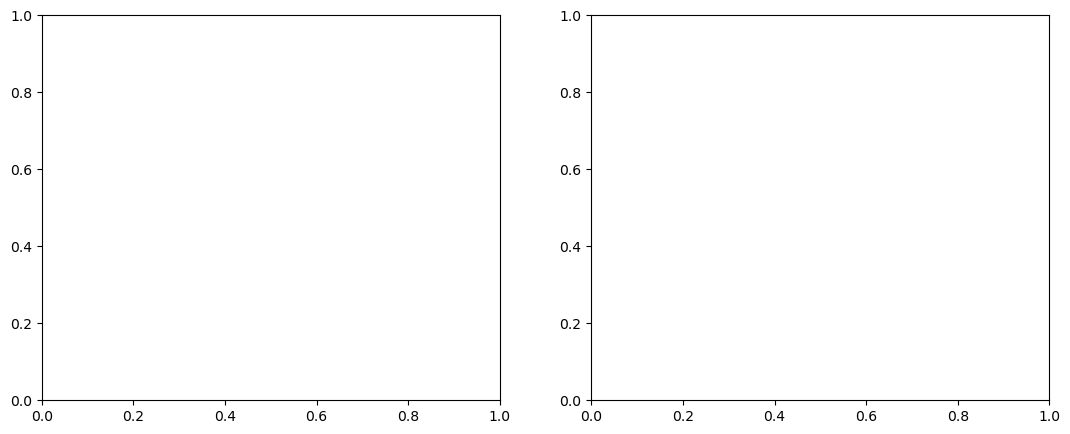

In [146]:
i = 1

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

                # --- Plot c1 on the first axis (ax1) ---
c1_triangle_values = c1_history[i][elements].sum(axis=1)
collection1 = PolyCollection(nodes[elements], cmap='viridis')
collection1.set_array(c1_triangle_values)
ax1.add_collection(collection1)
ax1.triplot(nodes[:, 0], nodes[:, 1], elements, 'k-', lw=0.5)
ax1.set_title(f"c1 ")
fig.colorbar(collection1, ax=ax1, label="Sum of nodal values")
ax1.autoscale_view()
ax1.set_aspect('equal')

                # --- Plot phi on the second axis (ax2) ---
phi_triangle_values = phi_history[i][elements].sum(axis=1)
collection2 = PolyCollection(nodes[elements], cmap='plasma')
collection2.set_array(phi_triangle_values)
ax2.add_collection(collection2)
ax2.triplot(nodes[:, 0], nodes[:, 1], elements, 'k-', lw=0.5)
ax2.set_title(f"phi ")
fig.colorbar(collection2, ax=ax2, label="Sum of nodal values")
ax2.autoscale_view()
ax2.set_aspect('equal')

                # --- Finalize and show the plot ---
plt.tight_layout()
plt.show()

In [ ]:
from utils.fem_mesh import create_structured_mesh, TriangularMesh



nx, ny = 30, 30
Lx, Ly = 1.0e-7, 1.0e-7
nodes, elements = create_structured_mesh(Lx=Lx, Ly=Ly, nx=nx, ny=ny)
mesh = TriangularMesh(nodes, elements)

ValueError: too many values to unpack (expected 2)

In [ ]:
nodes.shape

(961, 2)